In [1]:
# !pip install -q git+https://github.com/TimS-ML/Boring-Utils.git bertviz

import os; os.chdir('..')
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
# from transformers import GPT2LMHeadModel, GPT2Tokenizer

from boring_utils.utils import *

init_graph()
set_seed(42)
device = get_device()

  Preparing metadata (setup.py) ... done


# Model Loading

For distilgpt2:
```
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 6,
  "n_positions": 1024,
```

In [54]:
# since we gonna do some visualization, let's put it on cpu
# model_type = 'distilgpt2'
model_type = 'gpt2-medium'

# model_hf = GPT2LMHeadModel.from_pretrained(model_type)
# tokenizer_hf = GPT2Tokenizer.from_pretrained(model_type)

model = AutoModel.from_pretrained(model_type, output_attentions=True)
model_clm = AutoModelForCausalLM.from_pretrained(model_type)
tokenizer_hf = AutoTokenizer.from_pretrained(model_type)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [55]:
cprint(model.config.n_embd, model.config.n_head, model.config.n_layer, model.config.n_positions)

<cell line: 1> -> model.config.n_embd:
1024
<cell line: 1> -> model.config.n_head:
16
<cell line: 1> -> model.config.n_layer:
24
<cell line: 1> -> model.config.n_positions:
1024


NOTE: model_clm.transformer == model, that's why HF only downloads model once!

In [56]:
type(model_clm), type(model_clm.transformer), type(model)

(transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel,
 transformers.models.gpt2.modeling_gpt2.GPT2Model,
 transformers.models.gpt2.modeling_gpt2.GPT2Model)

# HF Export Attention Weights (with inputs)

In [57]:
# txt = "CS(=O)(=O)c1ccc8c5c1.O5C.N98.C9C#Cc1cc2c6cccc2n17.N6%10.C1%10CCN(C)CC1.C7C(F)(F)F"
txt = "The cat sat on the mat, the dog sat on the same mat."

In [58]:
inputs = tokenizer_hf.encode(txt, return_tensors='pt')

tokenizer_hf.pad_token = tokenizer_hf.eos_token
model_clm.config.pad_token_id = model_clm.config.eos_token_id
inputs_clm = tokenizer_hf(txt, return_tensors='pt', padding=True)  # NOTE: this is not tok.encode

In [59]:
cprint(inputs)

<cell line: 1> -> inputs:
tensor([[ 464, 3797, 3332,  319,  262, 2603,   11,  262, 3290, 3332,  319,  262,
          976, 2603,   13]])


In [60]:
cprint(inputs_clm)

<cell line: 1> -> inputs_clm:
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'input_ids': tensor([[ 464, 3797, 3332,  319,  262, 2603,   11,  262, 3290, 3332,  319,  262,
          976, 2603,   13]])}


In [61]:
outputs = model(
        inputs,
    )

In [62]:
# max_new_tokens is to fix the ValueError: Input length of input_ids is 68, but `max_length` is set to 20.
# This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.
outputs_dict = model_clm.generate(
        inputs_clm.input_ids,
        attention_mask=inputs_clm.attention_mask,
        output_attentions=True,  # we need to add this line to get the attention
        return_dict_in_generate=True,
        use_cache = True,
        max_new_tokens=len(inputs_clm.input_ids)+20  # make sure we get some generation
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [63]:
outputs_dictb = model_clm.generate(
        inputs,
        output_attentions=True,  # we need to add this line to get the attention
        return_dict_in_generate=True,
        use_cache = True,
        max_new_tokens=len(inputs)+20  # make sure we get some generation
    )

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Compare AutoModel(inputs) vs AutoModelForCausalLM.generate(inputs) and their attention masks

In [64]:
type(outputs), type(outputs_dict)

(transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions,
 transformers.generation.utils.GenerateDecoderOnlyOutput)

In [65]:
cprint(outputs.keys(), outputs_dict.keys())

<cell line: 1> -> outputs.keys():
odict_keys(['last_hidden_state', 'past_key_values', 'attentions'])
<cell line: 1> -> outputs_dict.keys():
odict_keys(['sequences', 'attentions', 'past_key_values'])


NOTE: Since there is no "generation head" for AutoModel, so the "attentions" here is more like the embedding purpuse, i.e. the input embedding.

In [66]:
# outputs[-1] == outputs['attentions']  # True
# outputs['attentions'][0] == outputs_dict['attentions'][0][0]  # True
# outputs['attentions'][0][0] == outputs_dict['attentions'][0][0].squeeze(0)  # True

cprint(len(inputs[0]))

tprint("AutoModelForCausalLM Embedding + Generation, padding")
cprint(outputs_dict["attentions"][0][0].shape, outputs_dict["attentions"][0][-1].shape)
cprint(outputs_dict["attentions"][-1][0].shape, outputs_dict["attentions"][-1][-1].shape)

tprint("AutoModelForCausalLM Embedding + Generation, no padding")
cprint(outputs_dictb["attentions"][0][0].shape, outputs_dictb["attentions"][0][-1].shape)
cprint(outputs_dictb["attentions"][-1][0].shape, outputs_dictb["attentions"][-1][-1].shape)

tprint("AutoModel Embedding")
cprint(outputs['attentions'][0].shape)

<cell line: 5> -> len(inputs[0]):
15

==================== AutoModelForCausalLM Embedding + Generation, padding ====================
<cell line: 8> -> outputs_dict["attentions"][0][0].shape:
torch.Size([1, 16, 15, 15])
<cell line: 8> -> outputs_dict["attentions"][0][-1].shape:
torch.Size([1, 16, 15, 15])
<cell line: 9> -> outputs_dict["attentions"][-1][0].shape:
torch.Size([1, 16, 1, 35])
<cell line: 9> -> outputs_dict["attentions"][-1][-1].shape:
torch.Size([1, 16, 1, 35])

==================== AutoModelForCausalLM Embedding + Generation, no padding ====================
<cell line: 12> -> outputs_dictb["attentions"][0][0].shape:
torch.Size([1, 16, 15, 15])
<cell line: 12> -> outputs_dictb["attentions"][0][-1].shape:
torch.Size([1, 16, 15, 15])
<cell line: 13> -> outputs_dictb["attentions"][-1][0].shape:
torch.Size([1, 16, 1, 35])
<cell line: 13> -> outputs_dictb["attentions"][-1][-1].shape:
torch.Size([1, 16, 1, 35])

==================== AutoModel Embedding ====================
<cell

In [67]:
cprint(outputs_dict["attentions"][0][0].shape, outputs_dict["attentions"][1][0].shape, outputs_dict["attentions"][-1][0].shape)

<cell line: 1> -> outputs_dict["attentions"][0][0].shape:
torch.Size([1, 16, 15, 15])
<cell line: 1> -> outputs_dict["attentions"][1][0].shape:
torch.Size([1, 16, 1, 16])
<cell line: 1> -> outputs_dict["attentions"][-1][0].shape:
torch.Size([1, 16, 1, 35])


In [68]:
# 6 transformer layers and 12 attention heads for distrilgpt
cprint(len(outputs['attentions']), len(outputs['attentions'][0][0]))

<cell line: 2> -> len(outputs['attentions']):
24
<cell line: 2> -> len(outputs['attentions'][0][0]):
16


## Bertviz Head View / Visualization

```
pip install bertviz
```

The architecture of the model and the characteristics of the generation process should be taken into account during the analysis. For example, in autoregressive generation, newly generated tokens can only pay attention to existing tokens, which will affect the distribution of attention.

Color means each attention heads, for distilgpt2 it's 12, for gpt2-medium it's 16.

In [69]:
from bertviz import head_view

attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer_hf.convert_ids_to_tokens(inputs[0])
head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [70]:
for i, attn in enumerate(outputs["attentions"]):
    print(f"Step {i}:")
    print(attn[0][0][0][:])
    print()

Step 0:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 1:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 2:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 3:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 4:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 5:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 6:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 7:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

Step 8:
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SliceBackward0>)

S

## Manual Visualization

NOTE: Each layer can be viewed as a time step in the processing sequence.

Lower layers may focus on more local features, while higher layers may focus on more global semantic information.

### get_top_attention

In [71]:
def get_top_attention(attn_weights, tokens, top_k=5):
    # Get attention weights for the last token
    last_token_attention = attn_weights[:, -1, :]

    # Calculate average attention across all heads
    mean_attention = last_token_attention.mean(dim=0)

    # Get top_k indices and values
    top_values, top_indices = torch.topk(mean_attention, k=top_k)

    # Return results
    return [(tokens[i], value.item()) for i, value in zip(top_indices, top_values)]


# Convert input tensor to list of token IDs
input_ids = inputs[0].tolist()  # Assuming inputs is a batch with one sequence

# Convert token IDs to tokens
tokens = tokenizer_hf.convert_ids_to_tokens(input_ids)

for i, attn in enumerate(outputs["attentions"]):
    print(f"Step {i}:")
    top_attentions = get_top_attention(attn[0], tokens)  # batch 0
    for token, value in top_attentions:
        print(f"  {token}: {value:.4f}")
    print()

Step 0:
  The: 0.1832
  .: 0.1082
  Ġsat: 0.0654
  Ġmat: 0.0651
  Ġsame: 0.0616

Step 1:
  The: 0.2897
  .: 0.1083
  ,: 0.0619
  Ġthe: 0.0568
  Ġon: 0.0561

Step 2:
  The: 0.1757
  .: 0.1739
  Ġthe: 0.0817
  Ġon: 0.0740
  Ġmat: 0.0622

Step 3:
  The: 0.2500
  .: 0.2165
  Ġsame: 0.0885
  Ġmat: 0.0810
  Ġthe: 0.0754

Step 4:
  The: 0.3780
  .: 0.1950
  Ġmat: 0.0972
  Ġsat: 0.0410
  ,: 0.0382

Step 5:
  The: 0.5027
  .: 0.1060
  Ġmat: 0.0826
  Ġsat: 0.0556
  Ġsame: 0.0493

Step 6:
  The: 0.6956
  .: 0.0825
  Ġmat: 0.0706
  ,: 0.0280
  Ġthe: 0.0189

Step 7:
  The: 0.5725
  .: 0.1076
  Ġsame: 0.0669
  Ġsat: 0.0458
  Ġthe: 0.0278

Step 8:
  The: 0.5454
  .: 0.1035
  Ġsame: 0.0539
  Ġmat: 0.0503
  Ġsat: 0.0411

Step 9:
  The: 0.7096
  .: 0.0478
  Ġthe: 0.0360
  Ġdog: 0.0325
  Ġsat: 0.0263

Step 10:
  The: 0.6406
  .: 0.0593
  Ġsame: 0.0412
  Ġmat: 0.0353
  Ġdog: 0.0331

Step 11:
  The: 0.4914
  .: 0.0842
  Ġsat: 0.0567
  Ġthe: 0.0542
  Ġdog: 0.0464

Step 12:
  The: 0.6970
  .: 0.0509
  Ġdog: 

### plot_attention_heatmap

Step 0:


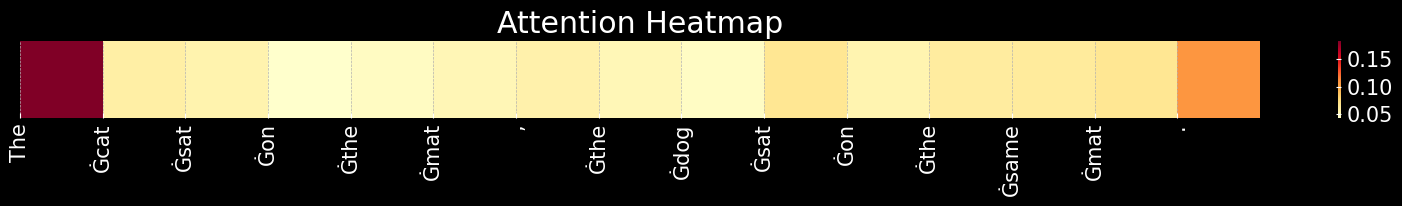


Step 1:


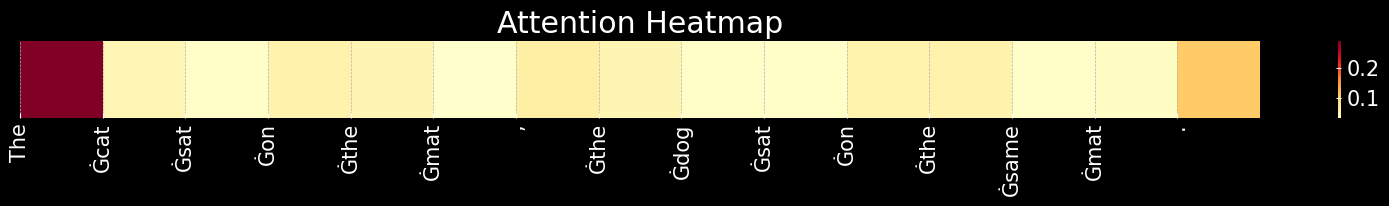


Step 2:


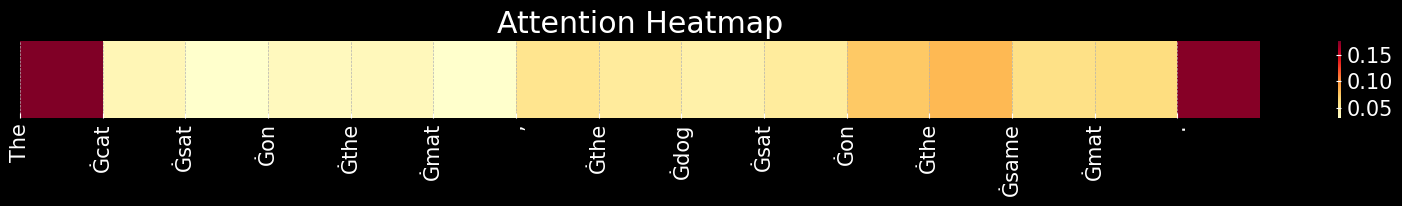


Step 3:


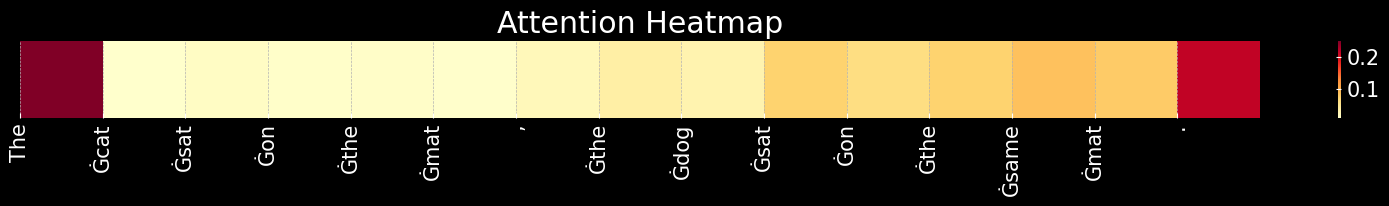


Step 4:


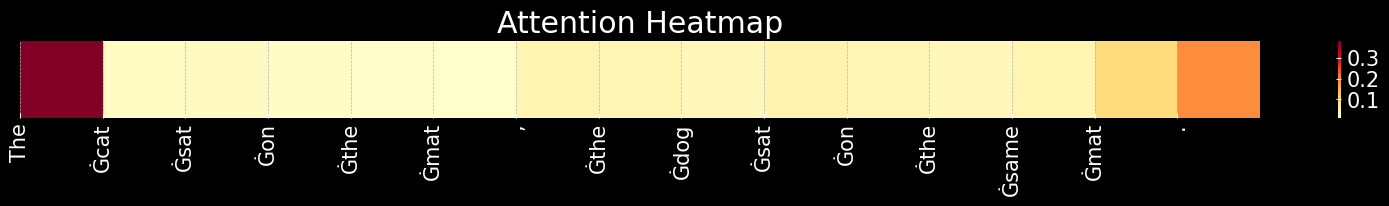


Step 5:


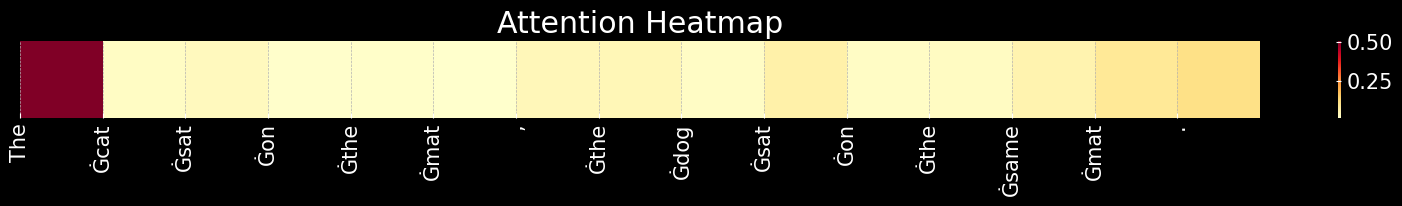


Step 6:


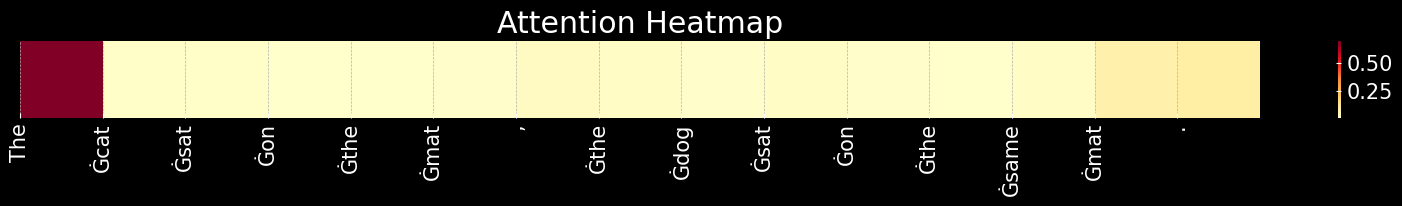


Step 7:


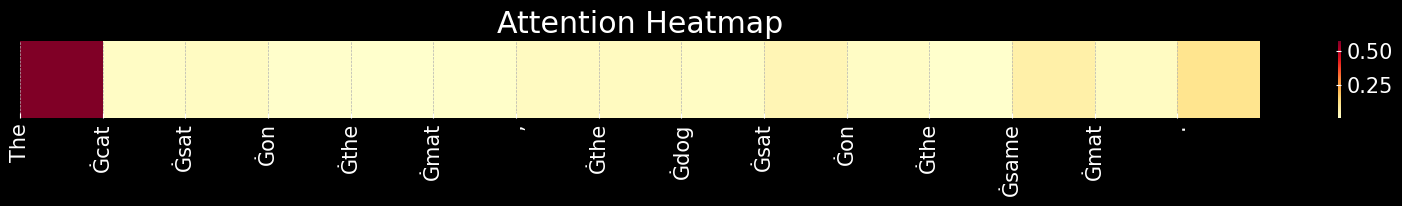


Step 8:


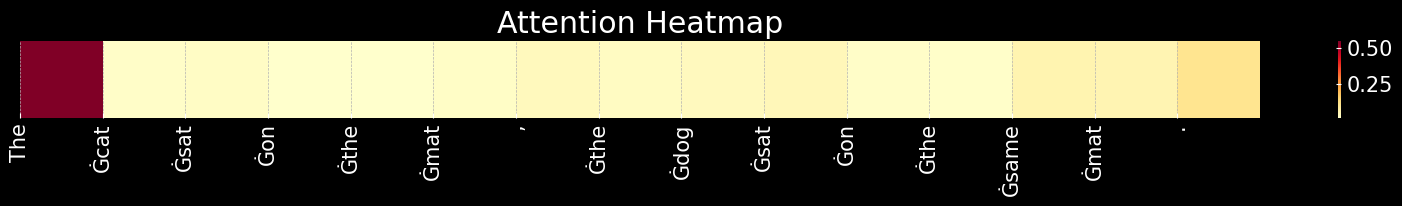


Step 9:


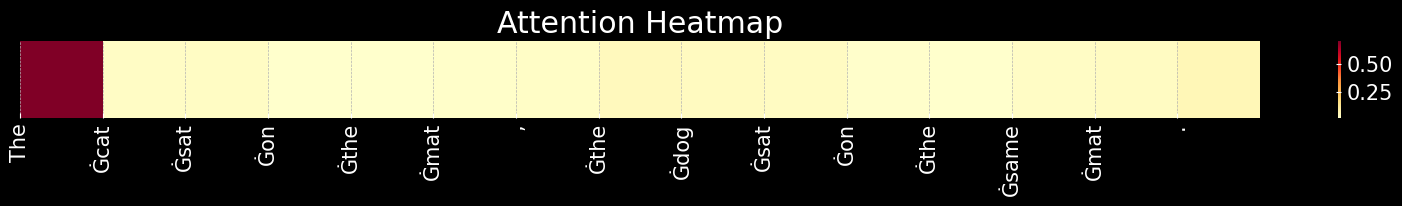


Step 10:


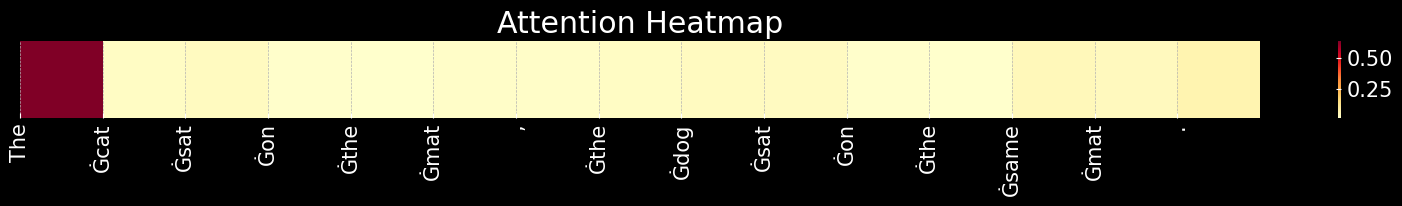


Step 11:


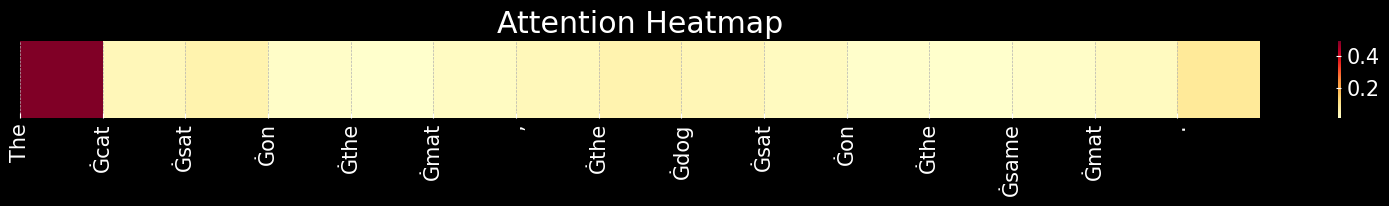


Step 12:


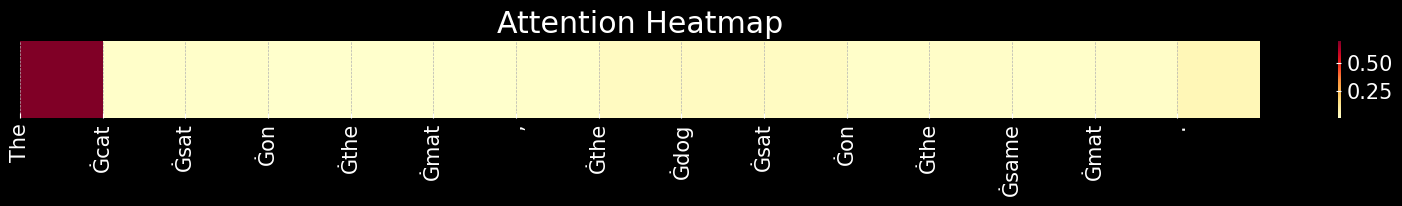


Step 13:


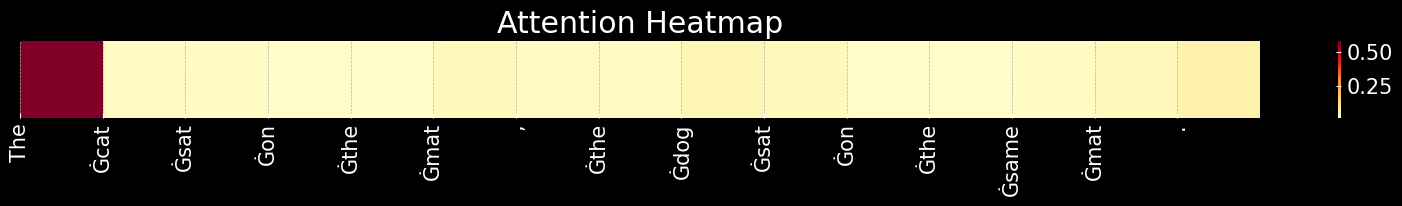


Step 14:


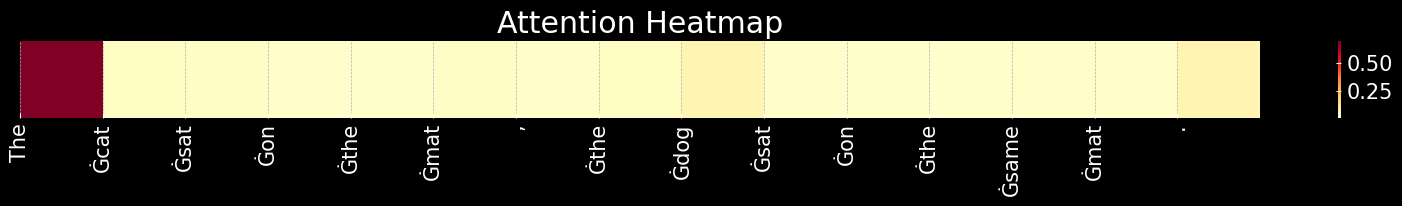


Step 15:


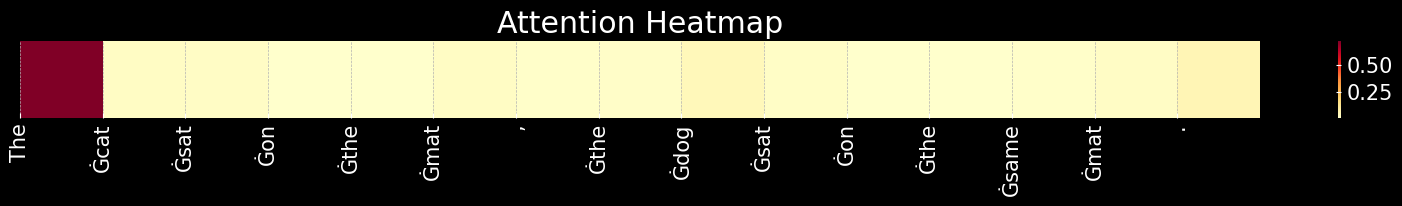


Step 16:


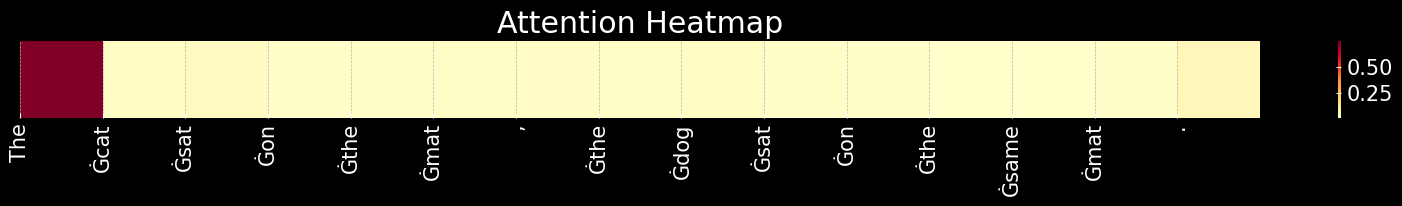


Step 17:


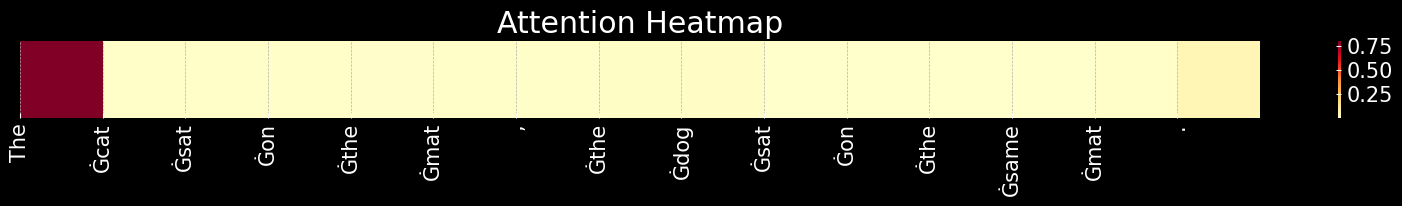


Step 18:


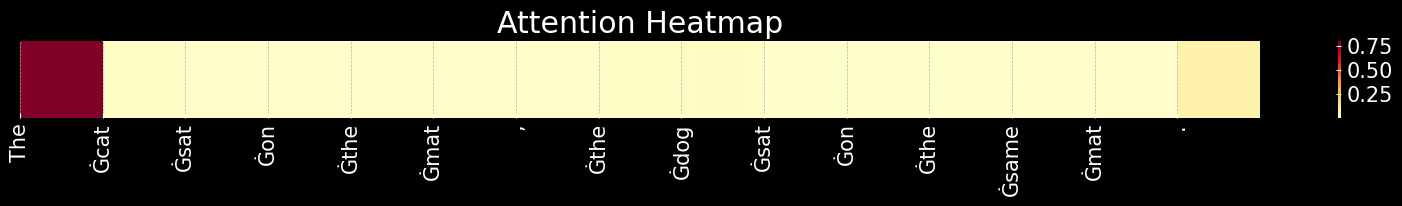


Step 19:


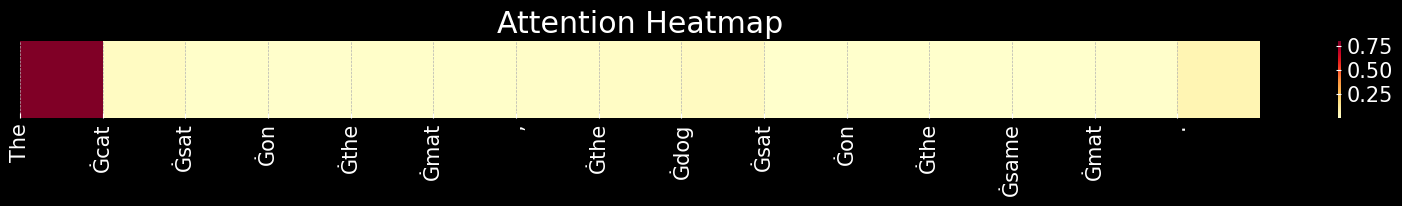


Step 20:


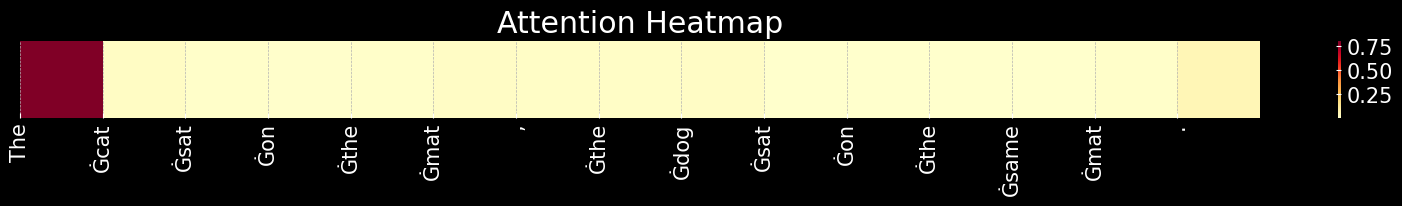


Step 21:


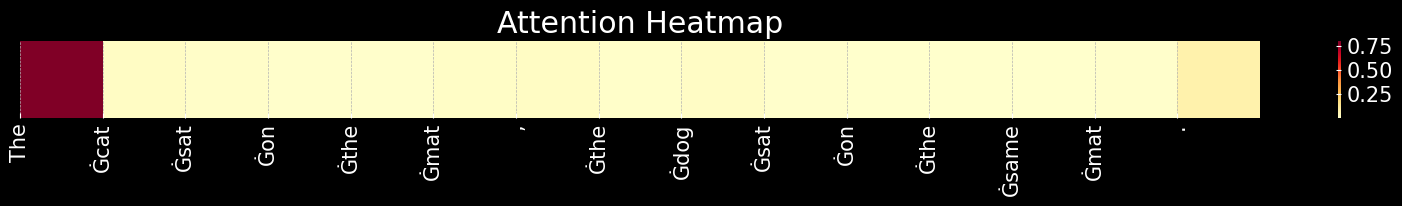


Step 22:


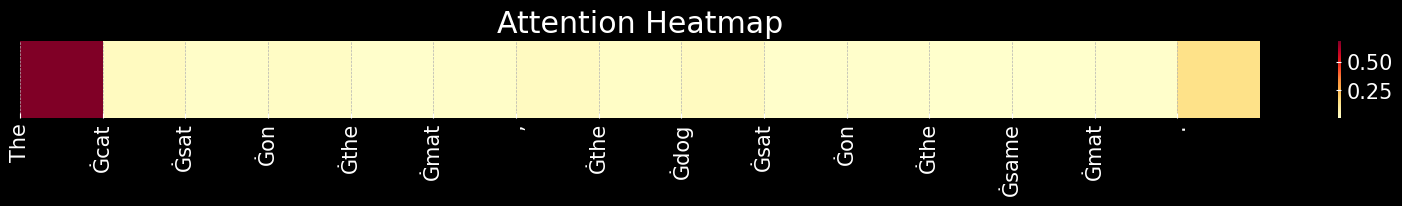


Step 23:


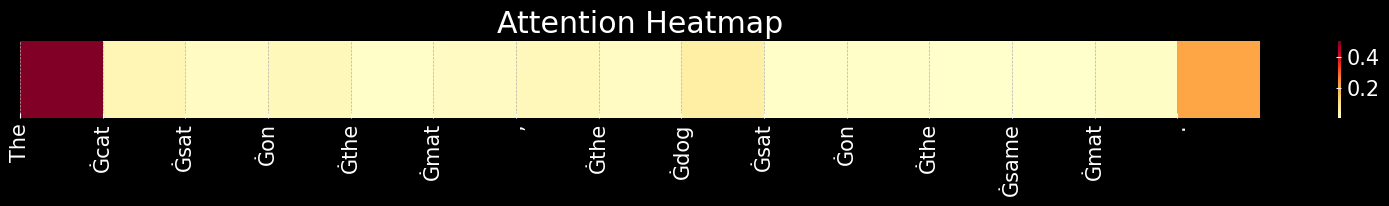

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(attn_weights, tokens):
    # Get attention weights for the last token
    last_token_attention = attn_weights[:, -1, :]

    # Calculate average attention across all heads
    mean_attention = last_token_attention.mean(dim=0)

    # Create heatmap
    plt.figure(figsize=(20, 1))
    sns.heatmap(mean_attention.unsqueeze(0).detach().numpy(), annot=False, cmap='YlOrRd')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.yticks([])
    plt.title("Attention Heatmap")
    plt.show()

# Convert input tensor to list of token IDs
input_ids = inputs[0].tolist()  # Assuming inputs is a batch with one sequence

# Convert token IDs to tokens
tokens = tokenizer_hf.convert_ids_to_tokens(input_ids)

for i, attn in enumerate(outputs["attentions"]):
    print(f"Step {i}:")
    plot_attention_heatmap(attn[0], tokens)
    print()

### track_token_attention

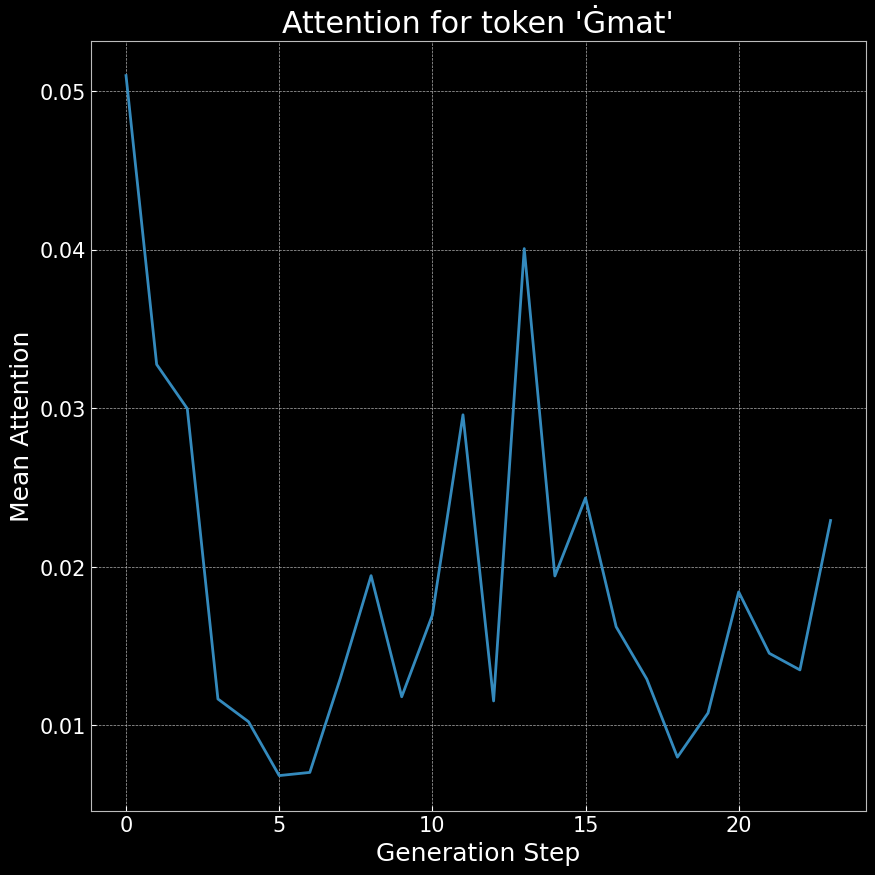

In [73]:
def track_token_attention(attentions, token_index):
    attention_over_time = []
    for attn in attentions:
        last_token_attention = attn[0, :, -1, token_index]
        mean_attention = last_token_attention.mean().item()
        attention_over_time.append(mean_attention)
    return attention_over_time

# Convert input tensor to list of token IDs
input_ids = inputs[0].tolist()  # Assuming inputs is a batch with one sequence

# Convert token IDs to tokens
tokens = tokenizer_hf.convert_ids_to_tokens(input_ids)

token_index = 5  # Assume we want to track the 5th token
attention_trend = track_token_attention(outputs["attentions"], token_index)

plt.plot(attention_trend)
plt.title(f"Attention for token '{tokens[token_index]}'")
plt.xlabel("Generation Step")
plt.ylabel("Mean Attention")
plt.show()

# HF Export Attention Weights (direct gen)

In [74]:
outputs2_dict = model_clm.generate(
        pad_token_id=tokenizer_hf.eos_token_id,
        output_attentions=True,
        return_dict_in_generate=True,
        use_cache = True,
        max_new_tokens=20
    )

In [75]:
outputs2_dict.keys()

odict_keys(['sequences', 'attentions', 'past_key_values'])

In [76]:
cprint(outputs2_dict["attentions"][0][0].shape, outputs2_dict["attentions"][0][-1].shape)
cprint(outputs2_dict["attentions"][-1][0].shape, outputs2_dict["attentions"][-1][-1].shape)

<cell line: 1> -> outputs2_dict["attentions"][0][0].shape:
torch.Size([1, 16, 1, 1])
<cell line: 1> -> outputs2_dict["attentions"][0][-1].shape:
torch.Size([1, 16, 1, 1])
<cell line: 2> -> outputs2_dict["attentions"][-1][0].shape:
torch.Size([1, 16, 1, 20])
<cell line: 2> -> outputs2_dict["attentions"][-1][-1].shape:
torch.Size([1, 16, 1, 20])


In [77]:
generated_ids = outputs2_dict.sequences[0]
generated_tokens2 = tokenizer_hf.convert_ids_to_tokens(generated_ids)
attentions2 = outputs2_dict.attentions

print(type(attentions2))
print(len(attentions2))
if len(attentions2) > 0:
    print(type(attentions2[0]))
    print(type(attentions2[0][0]))
    print(attentions2[0][0].shape)

<class 'tuple'>
20
<class 'tuple'>
<class 'torch.Tensor'>
torch.Size([1, 16, 1, 1])


In [78]:
import torch
from bertviz import head_view

def reconstruct_attention_matrix(attentions):
    num_layers = len(attentions[0])
    num_heads = attentions[0][0].shape[1]
    seq_len = len(attentions) + 1

    # Initialize the full attention matrix
    full_attention = torch.zeros((num_layers, 1, num_heads, seq_len, seq_len))

    # Fill in the attention matrix
    for i, attn_step in enumerate(attentions):
        for layer in range(num_layers):
            attn = attn_step[layer][0]  # Shape: [num_heads, 1, i+1]
            full_attention[layer, 0, :, i+1, :attn.shape[-1]] = attn.squeeze(1)

    return full_attention


# Reconstruct the full attention matrix
full_attention = reconstruct_attention_matrix(attentions2)

# Print shapes for verification
print("Full attention shape:", full_attention.shape)
print("Number of tokens:", len(generated_tokens2))

# Now we can use head_view
head_view(
    full_attention,  # Pass the entire attention tensor
    generated_tokens2
)

Full attention shape: torch.Size([24, 1, 16, 21, 21])
Number of tokens: 21


<IPython.core.display.Javascript object>